#### url :https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-cbow.html
#### Title: Supercharging modern data centers with NVIDIA networking solutions Supercharging modern data centers with NVIDIA Implementing Deep Learning Methods and Feature Engineering for Text Data: The Continuous Bag of Words (CBOW)
#### Author: Dipanjan Sarkar

##### 1. How would you incorporate other vectorizations than tf-idf into your proposed document similarity measure (Question 3 of Week 2)?

In [ ]:
import numpy as np
import pandas as pd 
# Plotting library
import matplotlib
import matplotlib.pyplot as plt
# Plot graphs within ipython notebook
%matplotlib inline

# Python Natural Language Tool Kit
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
file = file = open("metamorphosis_clean.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  ﻿One morning, when Gregor Samsa woke from troubled dreams, he found

The Last Line:  first to get up and stretch out her young body.


In [ ]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('\ ', '')

In [ ]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
tokens = word_tokenize(data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from nltk.corpus import stopwords
skip=set(stopwords.words('english'))
#initializing the snowball stemmer that will convert the words to their root meaning
sno=nltk.stem.SnowballStemmer('english')

In [ ]:
wordsFiltered = []
for w in data.split():
    if w not in skip:
        wordsFiltered.append(w)

In [ ]:
df = ' '.join(wordsFiltered)

In [ ]:
new_data = [sno.stem(w) for w in df.split()]
new = ' '
for x in new_data:
    new += ' ' + x

In [ ]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(new.split())
word2id = tokenizer.word_index
# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in new.split()]
vocab_size = len(word2id)
embed_size = 100
window_size = 3 # context window size
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:200])


Vocabulary Size: 2301
Vocabulary Sample: [('now', 1), ('gregor', 2), ('it', 3), ('that', 4), ('well', 5), ('mother', 6), ('he', 7), ('father', 8), ('work', 9), ('then', 10), ('grete', 11), ('what', 12), ('pain', 13), ('there', 14), ('come', 15), ('open', 16), ('help', 17), ('samsa', 18), ('bed', 19), ('hard', 20), ('room', 21), ('look', 22), ('god', 23), ('out', 24), ('like', 25), ('let', 26), ('hope', 27), ('move', 28), ('yes', 29), ('round', 30), ('no', 31), ('on', 32), ('door', 33), ('imagin', 34), ('this', 35), ('so', 36), ('in', 37), ('one', 38), ('back', 39), ('moment', 40), ('him', 41), ('use', 42), ('get', 43), ('before', 44), ('home', 45), ('time', 46), ('know', 47), ('go', 48), ('place', 49), ('soon', 50), ('enough', 51), ('other', 52), ('live', 53), ('would', 54), ('long', 55), ('and', 56), ('close', 57), ('quiet', 58), ('seven', 59), ('you', 60), ('sister', 61), ('continu', 62), ('said', 63), ('himself', 64), ('stay', 65), ('calm', 66), ('again', 67), ('here', 68), ('anyway

In [ ]:
from keras_preprocessing.sequence import pad_sequences
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)
            



In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy',  optimizer='rmsprop')

# view model summary
print(cbow.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 6, 100)            230100    
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 2301)              232401    
                                                                 
Total params: 462,501
Trainable params: 462,501
Non-trainable params: 0
_________________________________________________________________
None


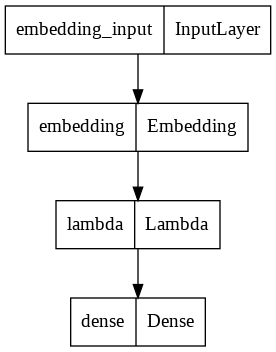

In [ ]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(cbow, to_file='model.png', show_layer_names=True)

In [ ]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Epoch: 1 	Loss: 29160.260709762573

Epoch: 2 	Loss: 27742.961939573288

Epoch: 3 	Loss: 26604.22905778885

Epoch: 4 	Loss: 25812.739891529083

Epoch: 5 	Loss: 25282.35440659523



In [ ]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(2300, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
gregor,0.023744,-0.040685,-0.036144,-0.024317,-0.038357,-0.035918,-0.013021,-0.041291,-0.024223,-0.018698,...,-0.038298,-0.027892,0.044938,0.014883,-0.025828,0.007021,-0.006605,-0.006175,-0.041897,0.018853
it,-0.005489,-0.004025,0.005495,0.007808,0.038068,-0.037266,-0.049462,-0.044340,-0.019140,0.008943,...,0.013930,0.040223,0.017877,-0.039958,0.023830,0.000278,-0.026621,-0.027981,0.010081,-0.043598
that,0.034596,-0.001590,0.047709,0.023958,0.024312,-0.005177,-0.043517,-0.016345,0.029024,-0.027924,...,0.026836,0.040550,0.038178,0.001025,-0.024915,0.019018,-0.032302,-0.019508,0.025517,-0.008339
well,-0.026541,-0.032514,0.047808,-0.031878,0.019679,-0.034412,-0.025110,0.019208,-0.005094,0.030039,...,0.002275,0.016265,-0.048974,0.018243,-0.024466,-0.047905,0.023342,0.021258,-0.024924,0.012331
mother,0.014884,-0.008076,0.017179,-0.004465,0.014020,-0.028612,0.049106,-0.024296,0.021498,-0.016259,...,0.040421,-0.027437,-0.054026,-0.003026,-0.008350,-0.026527,0.039220,0.009300,0.038524,-0.005104


In [ ]:
document_embeddings = pd.DataFrame(weights, index=list(id2word.values())[1:])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances


In [ ]:
pairwise_similarities=cosine_similarity(document_embeddings)

pairwise_differences=euclidean_distances(document_embeddings)

In [ ]:
pairwise_similarities

array([[ 0.99999994,  0.01896471,  0.10725815, ...,  0.03844744,
        -0.02350457, -0.11420418],
       [ 0.01896471,  1.0000001 ,  0.21892357, ...,  0.06014183,
        -0.00970269, -0.07788887],
       [ 0.10725815,  0.21892357,  0.9999998 , ...,  0.1077636 ,
         0.00876198, -0.16427895],
       ...,
       [ 0.03844744,  0.06014183,  0.1077636 , ...,  0.99999994,
        -0.0011755 ,  0.02129892],
       [-0.02350457, -0.00970269,  0.00876198, ..., -0.0011755 ,
         1.0000001 , -0.05249636],
       [-0.11420418, -0.07788887, -0.16427895, ...,  0.02129892,
        -0.05249636,  1.        ]], dtype=float32)

In [ ]:
pairwise_differences

array([[0.        , 0.4071224 , 0.39082617, ..., 0.4118986 , 0.4243351 ,
        0.4172602 ],
       [0.4071224 , 0.        , 0.35077012, ..., 0.39131042, 0.40493625,
        0.39248756],
       [0.39082617, 0.35077012, 0.        , ..., 0.38372654, 0.40381527,
        0.41081995],
       ...,
       [0.4118986 , 0.39131042, 0.38372654, ..., 0.        , 0.4124278 ,
        0.38376558],
       [0.4243351 , 0.40493625, 0.40381527, ..., 0.4124278 , 0.        ,
        0.39717108],
       [0.4172602 , 0.39248756, 0.41081995, ..., 0.38376558, 0.39717108,
        0.        ]], dtype=float32)

#### 2. How could one make use these other vectorizations to improve sentiment analysis by considering longer sequences within the text just than single words?

##### URL: https://datasciencetoday.net/index.php/en-us/tutorials-top/162-sentiment-analysis-using-python-part-ii-doc2vec-vs-word2vec
##### Title : Sentiment Analysis using Python (Part II - Doc2vec vs Word2vec)
##### Author : Oumaima Hourrane

In [ ]:
dataset = pd.read_csv('/content/movie_reviews (1).csv.bz2', compression='bz2')
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
from sklearn.model_selection import train_test_split
SEED = 999

x_train, x_validation, y_train, y_validation = train_test_split(dataset.review, dataset.sentiment, test_size=.25, random_state=SEED)

In [ ]:
import gensim
from gensim.models.doc2vec import TaggedDocument
def labelize_text(text,label):
    result = []
    prefix = label
    for i, t in zip(text.index, text):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result
  
all_x = pd.concat([x_train,x_validation])

all_x_w2v = labelize_text(all_x, 'ALL')
x_train = labelize_text(x_train, 'TRAIN')
x_validation = labelize_text(x_validation, 'TEST')

In [ ]:
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm
from sklearn import utils
import numpy as np

model_w2v = Word2Vec(size=200, min_count=10)
model_w2v.build_vocab([x.words for x in tqdm(all_x_w2v)])
model_w2v.train([x.words for x in tqdm(all_x_w2v)], total_examples=len(all_x_w2v), epochs=1)

100%|██████████| 50000/50000 [00:00<00:00, 2496728.42it/s]


(8367639, 11557847)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in all_x_w2v])
tfidf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))

def build_Word_Vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: 
            
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
y_validation = y_validation.replace('negative', 0).replace('positive', 1)
y_train= y_train.replace('negative', 0).replace('positive', 1)

In [ ]:
from sklearn.preprocessing import scale
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

train_vecs_w2v = np.concatenate([build_Word_Vector(z, 200) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)
val_vecs_w2v = np.concatenate([build_Word_Vector(z, 200) for z in tqdm(map(lambda x: x.words, x_validation))])
val_vecs_w2v = scale(val_vecs_w2v)


model = Sequential()
model.add(Dense(256, activation='relu', input_dim=200))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_vecs_w2v, y_train, epochs=100, batch_size=32, verbose=2)

score = model.evaluate(val_vecs_w2v, y_validation, batch_size=128, verbose=2)
print(score[1])

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
37500it [01:11, 521.91it/s]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
12500it [00:27, 452.02it/s]


Train on 37500 samples
Epoch 1/100
37500/37500 - 3s - loss: 0.5065 - accuracy: 0.7581 - 3s/epoch - 72us/sample
Epoch 2/100
37500/37500 - 2s - loss: 0.4768 - accuracy: 0.7746 - 2s/epoch - 66us/sample
Epoch 3/100
37500/37500 - 2s - loss: 0.4668 - accuracy: 0.7802 - 2s/epoch - 67us/sample
Epoch 4/100
37500/37500 - 2s - loss: 0.4574 - accuracy: 0.7858 - 2s/epoch - 64us/sample
Epoch 5/100
37500/37500 - 2s - loss: 0.4517 - accuracy: 0.7882 - 2s/epoch - 66us/sample
Epoch 6/100
37500/37500 - 2s - loss: 0.4451 - accuracy: 0.7898 - 2s/epoch - 64us/sample
Epoch 7/100
37500/37500 - 2s - loss: 0.4381 - accuracy: 0.7950 - 2s/epoch - 64us/sample
Epoch 8/100
37500/37500 - 2s - loss: 0.4298 - accuracy: 0.7995 - 2s/epoch - 64us/sample
Epoch 9/100
37500/37500 - 2s - loss: 0.4207 - accuracy: 0.8039 - 2s/epoch - 65us/sample
Epoch 10/100
37500/37500 - 2s - loss: 0.4115 - accuracy: 0.8075 - 2s/epoch - 62us/sample
Epoch 11/100
37500/37500 - 2s - loss: 0.3986 - accuracy: 0.8150 - 2s/epoch - 64us/sample
Epoch 1

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


0.73864


##### 3. Would text prediction (like the auto-completion of Question 2 of Week 6) be easier in some way if these other vectorizations are taken into consideration? How and why?

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
train_len = 3
text_sequences = []
for i in range(train_len,len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)
sequences = {}
count = 1
for i in range(len(tokens)):
    if tokens[i] not in sequences:
        sequences[tokens[i]] = count
        count += 1
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)

In [ ]:
max_sequence_len = max([len(x) for x in sequences])
input_sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences

array([[ 304,  152,    1],
       [ 152,    1,  305],
       [   1,  305,   15],
       ...,
       [   1, 2584,  306],
       [2584,  306,  722],
       [ 306,  722,    1]], dtype=int32)

In [ ]:
#Collecting some information   
vocabulary_size = len(tokenizer.word_counts)+1

n_sequences = np.empty([len(sequences),train_len], dtype='int32')
for i in range(len(sequences)):
    n_sequences[i] = sequences[i]

In [ ]:
train_inputs = n_sequences[:,:-1]
train_targets = n_sequences[:,-1]
train_targets = to_categorical(train_targets, num_classes=vocabulary_size)
seq_len = train_inputs.shape[1]
train_inputs.shape

(5532, 2)

In [ ]:
train_inputs

array([[ 176,  362],
       [ 362,    1],
       [   1,   12],
       ...,
       [   1,  782],
       [ 782,  185],
       [ 185, 2301]], dtype=int32)

In [ ]:
train_targets

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau


checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
#model = load_model("mymodel.h5")

model = Sequential()
model.add(Embedding(vocabulary_size, seq_len, input_length=seq_len))
model.add(Bidirectional(LSTM(1000,return_sequences=True)))
model.add(Bidirectional(LSTM(1000)))
model.add(Dense(1000,activation='relu'))
model.add(Dense(vocabulary_size, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2, 2)              5170      
                                                                 
 bidirectional (Bidirectiona  (None, 2, 2000)          8024000   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 2000)             24008000  
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1000)              2001000   
                                                                 
 dense_1 (Dense)             (None, 2585)              2587585   
                                                                 
Total params: 36,625,755
Trainable params: 36,625,755
No

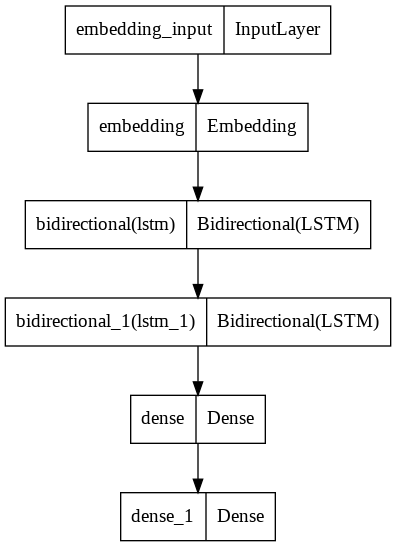

In [ ]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

In [ ]:
# compile network
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(train_inputs,train_targets,epochs=150, batch_size=64, callbacks=[checkpoint, reduce, es],verbose=1)
model.save("mymodel.h5")

Epoch 1/150
87/87 [==============================] - ETA: 0s - loss: 1.5200 - accuracy: 0.5343
Epoch 1: loss did not improve from 1.23326
87/87 [==============================] - 8s 27ms/step - loss: 1.5200 - accuracy: 0.5343 - lr: 0.0010
Epoch 2/150
86/87 [============================>.] - ETA: 0s - loss: 1.1897 - accuracy: 0.6072
Epoch 2: loss improved from 1.23326 to 1.19058, saving model to nextword1.h5
87/87 [==============================] - 4s 43ms/step - loss: 1.1906 - accuracy: 0.6068 - lr: 0.0010
Epoch 3/150
86/87 [============================>.] - ETA: 0s - loss: 1.1616 - accuracy: 0.6088
Epoch 3: loss improved from 1.19058 to 1.16377, saving model to nextword1.h5
87/87 [==============================] - 4s 43ms/step - loss: 1.1638 - accuracy: 0.6079 - lr: 0.0010
Epoch 4/150
85/87 [============================>.] - ETA: 0s - loss: 1.1924 - accuracy: 0.6020
Epoch 4: loss did not improve from 1.16377
87/87 [==============================] - 2s 27ms/step - loss: 1.1947 - accura

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

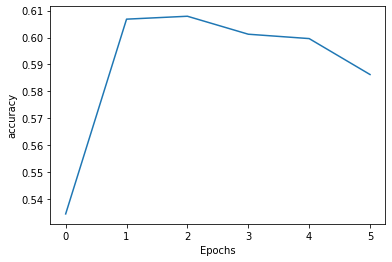

In [ ]:
plot_graphs(history, 'accuracy')

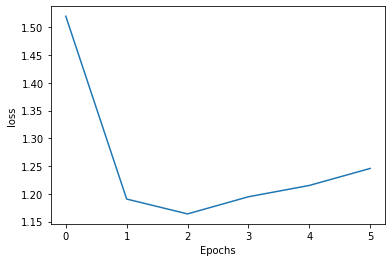

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
from keras_preprocessing.sequence import pad_sequences
input_text = input().strip().lower()
encoded_text = tokenizer.texts_to_sequences([input_text])[0]
pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, padding='pre', truncating='pre')
print(encoded_text, pad_encoded)
for i in (model.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
  pred_word = tokenizer.index_word[i]
  print("Next word suggestion:",pred_word)

she is in 
[74, 33, 28] [[33 28]]
1/1 [==============================] - 0s 21ms/step
Next word suggestion: lose
Next word suggestion: belly
Next word suggestion: !


##### 4. Compute and compare (k-means or other) clusterings (for a corpus of your choice) based on our three vectorizations — tf-idf, PPMI, and skipgram embeddings — in terms of some consistency measure such as the Rand or the Jaccard index. Discuss the differences you observe. Does the spacial grouping, in any of the three cases, appear to capture some sort of perceivable semantic similarity?


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm') 
doc = nlp(new)
sentences = [[sent.text.strip()] for sent in doc.sents]
  

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(sentences, size=100, min_count=1,workers=10)


In [ ]:
from sklearn.decomposition import PCA

# fit a 2d PCA model to the vectors
vectors = model[model.wv.vocab]
words = list(model.wv.vocab)
pca = PCA(n_components=5)
PCA_result = pca.fit_transform(vectors)

# prepare a dataframe
words = pd.DataFrame(words)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
PCA_data_complet =PCA_final[['word','x_values','y_values']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
# KNN analysis was carried out in Orange
# 6 clusters were automatically detected by Orange
knn = pd.read_csv('/content/knn result .csv').drop(labels=[0,1], axis=0).drop(labels = 'Unnamed: 0', axis = 1)
knn = knn.reset_index()

In [ ]:
result = knn.drop(labels = 'index', axis = 1)
result

,x_values,y_values,word,Cluster,Silhouette
0,-0.0028215402,-0.0056364546,"one morning, gregor samsa woke troubl dreams, ...",C2,0.6421893776163234
1,-3.5067802e-05,0.001643067,"he lay armour-lik back, lift head littl could ...",C2,0.49721753421725623
2,-0.00070192944,-0.001271875,the bed hard abl cover seem readi slide moment.,C2,0.6133153643185436
3,0.005030413,-0.003850557,"his mani legs, piti thin compar size rest him,...",C2,0.5678918648753679
4,0.0062433444,0.0064553423,"""what happen me?"" thought.",C4,0.6267928712598945
...,...,...,...,...,...
483,0.0010464382,-0.0060606855,"tram, sunshine, leant comfort seats, discuss c...",C3,0.5936795253892081
484,-0.008052381,-0.0010993255,livelier.,C5,0.6295586100078601
485,0.0063272184,-0.005376006,"cheek pale, talking, struck, simultaneously, b...",C3,0.6277425290327308
486,0.0045321253,0.00518677,quieter.,C1,0.6272430911341066


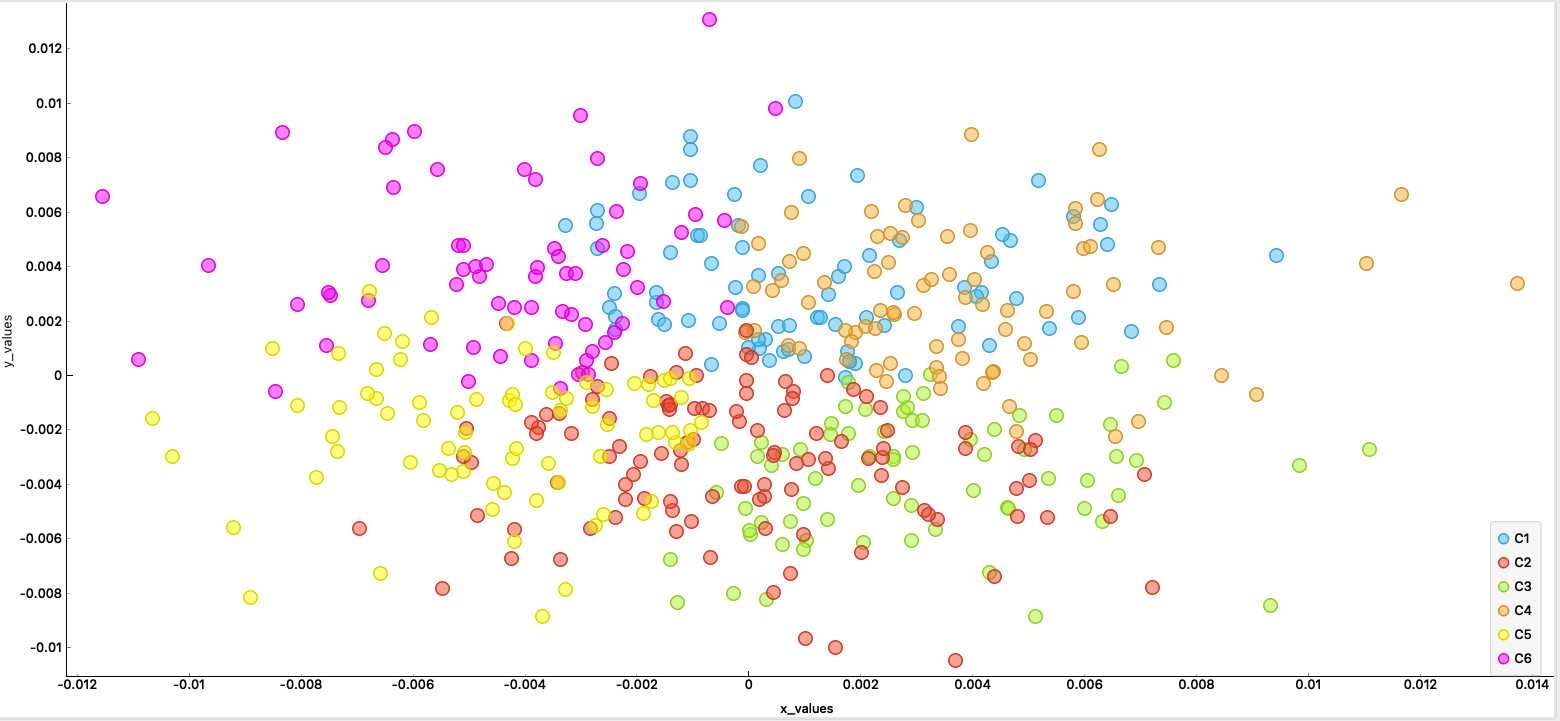